In [7]:
import pandas as pd
import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [9]:
print(df.columns)

Index(['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth',
       'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Language',
       'Bank', 'AccountType', 'MaritalStatus', 'Gender', 'Country', 'Province',
       'PostalCode', 'MainCrestaZone', 'SubCrestaZone', 'ItemType', 'mmcode',
       'VehicleType', 'RegistrationYear', 'make', 'Model', 'Cylinders',
       'cubiccapacity', 'kilowatts', 'bodytype', 'NumberOfDoors',
       'VehicleIntroDate', 'CustomValueEstimate', 'AlarmImmobiliser',
       'TrackingDevice', 'CapitalOutstanding', 'NewVehicle', 'WrittenOff',
       'Rebuilt', 'Converted', 'CrossBorder', 'NumberOfVehiclesInFleet',
       'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm',
       'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section',
       'Product', 'StatutoryClass', 'StatutoryRiskType', 'TotalPremium',
       'TotalClaims', 'RiskScore', 'HasClaim', 'ClaimSeverity', 'Margin'],
      dtype='object')


In [14]:

# Load data
df = pd.read_csv('data/insurance_data.csv')

# Define metrics
df['HasClaim'] = (df['TotalClaims'] > 0).astype(int)  # Claim Frequency
df['ClaimSeverity'] = df.loc[df['HasClaim'] == 1, 'TotalClaims']  # Claim Severity may contain NaNs
df['Margin'] = df['TotalPremium'] - df['TotalClaims']  # Margin

# Function to check equivalence between two groups
def check_equivalence(group1, group2, feature, is_categorical=True):
    if is_categorical:
        # Create frequency tables for each group
        freq1 = group1[feature].value_counts(dropna=False)
        freq2 = group2[feature].value_counts(dropna=False)

        # Combine into a common index to avoid missing categories
        combined_index = freq1.index.union(freq2.index)
        freq1 = freq1.reindex(combined_index, fill_value=0)
        freq2 = freq2.reindex(combined_index, fill_value=0)

        # Build contingency table
        contingency = pd.DataFrame({group1.name: freq1, group2.name: freq2})

        # Check for empty table
        if contingency.empty:
            raise ValueError(f"Contingency table for '{feature}' is empty. No data in either group.")

        # Perform chi-squared test
        chi2, p, _, _ = stats.chi2_contingency(contingency)
        return p
    else:
        # For numeric features: t-test
        sample1 = group1[feature].dropna()
        sample2 = group2[feature].dropna()

        if len(sample1) == 0 or len(sample2) == 0:
            raise ValueError(f"One of the samples for '{feature}' is empty. Cannot perform t-test.")

        t_stat, p = stats.ttest_ind(sample1, sample2)
        return p

# Example: Segment by Province (Gauteng vs Western Cape)
group_a = df[df['Province'] == 'Gauteng'].copy()
group_b = df[df['Province'] == 'Western Cape'].copy()

# Assign names for clearer output
group_a.name = 'Gauteng'
group_b.name = 'Western Cape'

# Check equivalence for other features (e.g., VehicleType, TotalPremium)
print("Equivalence p-values:")
try:
    vehicle_p = check_equivalence(group_a, group_b, 'VehicleType')
    print("VehicleType:", vehicle_p)
except Exception as e:
    print("VehicleType: Error -", e)

try:
    premium_p = check_equivalence(group_a, group_b, 'TotalPremium', is_categorical=False)
    print("TotalPremium:", premium_p)
except Exception as e:
    print("TotalPremium: Error -", e)

C:\Users\Daniel.Temesgen\AppData\Local\Temp\ipykernel_2356\2337752583.py:2: DtypeWarning: Columns (32,37) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/insurance_data.csv')


Equivalence p-values:
VehicleType: 0.0
TotalPremium: 3.260368633786302e-06


In [17]:
# Hypothesis 1: No risk differences across provinces
# Claim Frequency (Chi-squared)
contingency_province = pd.crosstab(df['Province'], df['HasClaim'])
chi2_province, p_province_freq, _, _ = stats.chi2_contingency(contingency_province)
print("H1 - Claim Frequency by Province: p =", p_province_freq)

# Claim Severity (ANOVA)
severity_by_province = [df[df['Province'] == p]['ClaimSeverity'].dropna() for p in df['Province'].unique()]
f_stat_province, p_province_sev = stats.f_oneway(*severity_by_province)
print("H1 - Claim Severity by Province: p =", p_province_sev)

# Hypothesis 2: No risk differences between zip codes
# Claim Frequency (Chi-squared)
contingency_zip = pd.crosstab(df['PostalCode'], df['HasClaim'])
chi2_zip, p_zip_freq, _, _ = stats.chi2_contingency(contingency_zip)
print("H2 - Claim Frequency by PostalCode: p =", p_zip_freq)

# Claim Severity (ANOVA)
severity_by_zip = [df[df['PostalCode'] == z]['ClaimSeverity'].dropna() for z in df['PostalCode'].unique()]
f_stat_zip, p_zip_sev = stats.f_oneway(*severity_by_zip)
print("H2 - Claim Severity by PostalCode: p =", p_zip_sev)

# Hypothesis 3: No margin difference between zip codes
margin_by_zip = [df[df['PostalCode'] == z]['Margin'].dropna() for z in df['PostalCode'].unique()]
f_stat_margin, p_margin = stats.f_oneway(*margin_by_zip)
print("H3 - Margin by PostalCode: p =", p_margin)

# Hypothesis 4: No risk difference between Women and Men
# Claim Frequency (Chi-squared)
contingency_gender = pd.crosstab(df['Gender'], df['HasClaim'])
chi2_gender, p_gender_freq, _, _ = stats.chi2_contingency(contingency_gender)
print("H4 - Claim Frequency by Gender: p =", p_gender_freq)

# Claim Severity (T-test)
severity_male = df[df['Gender'] == 'Male']['ClaimSeverity'].dropna()
severity_female = df[df['Gender'] == 'Female']['ClaimSeverity'].dropna()
t_stat_gender, p_gender_sev = stats.ttest_ind(severity_male, severity_female)
print("H4 - Claim Severity by Gender: p =", p_gender_sev)

H1 - Claim Frequency by Province: p = 5.925510718204678e-19
H1 - Claim Severity by Province: p = 6.304916760425176e-06
H2 - Claim Frequency by PostalCode: p = 3.152172246339057e-30


C:\Users\Daniel.Temesgen\AppData\Local\Temp\ipykernel_2356\213252188.py:20: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  f_stat_zip, p_zip_sev = stats.f_oneway(*severity_by_zip)


H2 - Claim Severity by PostalCode: p = nan
H3 - Margin by PostalCode: p = 0.9976859758015036
H4 - Claim Frequency by Gender: p = 0.026570248768437145
H4 - Claim Severity by Gender: p = 0.676015677644587


In [18]:
# Calculate effect sizes for significant results
# H1: Province differences
freq_by_province = df.groupby('Province')['HasClaim'].mean()
severity_by_province = df.groupby('Province')['ClaimSeverity'].mean()
print("Claim Frequency by Province:\n", freq_by_province)
print("Claim Severity by Province:\n", severity_by_province)

# H3: Margin by PostalCode
margin_by_zip = df.groupby('PostalCode')['Margin'].mean()
print("Margin by PostalCode:\n", margin_by_zip)

Claim Frequency by Province:
 Province
Eastern Cape     0.001648
Free State       0.001358
Gauteng          0.003356
KwaZulu-Natal    0.002845
Limpopo          0.002698
Mpumalanga       0.002428
North West       0.002436
Northern Cape    0.001254
Western Cape     0.002166
Name: HasClaim, dtype: float64
Claim Severity by Province:
 Province
Eastern Cape     27128.533277
Free State       32265.661085
Gauteng          22243.878396
KwaZulu-Natal    29609.487473
Limpopo          15171.294187
Mpumalanga       15979.553421
North West       16963.467035
Northern Cape    11186.313596
Western Cape     28095.849881
Name: ClaimSeverity, dtype: float64
Margin by PostalCode:
 PostalCode
1        -6.468455
2        -0.687882
4       113.947737
5      -145.725189
6        30.980985
           ...    
9781    -84.946280
9830    131.760895
9868    116.042377
9869     43.193631
9870     80.469292
Name: Margin, Length: 888, dtype: float64


C:\Users\Daniel.Temesgen\AppData\Local\Temp\ipykernel_2356\1979885831.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Province', y='HasClaim', data=df, palette='viridis')


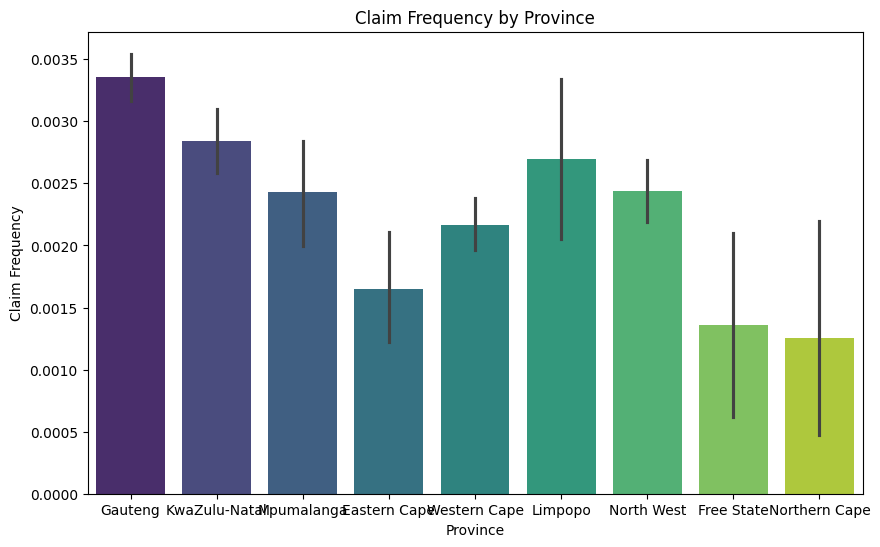

C:\Users\Daniel.Temesgen\AppData\Local\Temp\ipykernel_2356\1979885831.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='PostalCode', y='Margin', data=df, palette='magma')


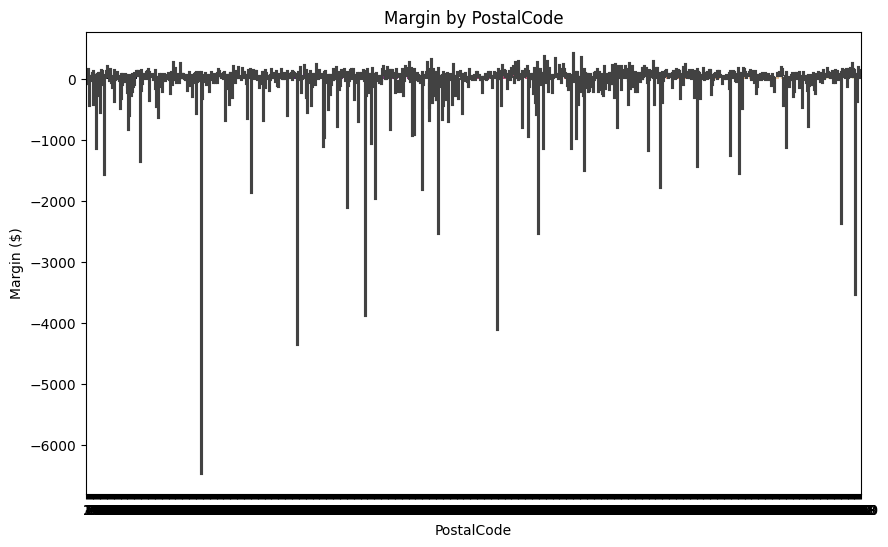

In [19]:
# Plot Claim Frequency by Province
plt.figure(figsize=(10, 6))
sns.barplot(x='Province', y='HasClaim', data=df, palette='viridis')
plt.title('Claim Frequency by Province')
plt.ylabel('Claim Frequency')
plt.show()

# Plot Margin by PostalCode
plt.figure(figsize=(10, 6))
sns.barplot(x='PostalCode', y='Margin', data=df, palette='magma')
plt.title('Margin by PostalCode')
plt.ylabel('Margin ($)')
plt.show()

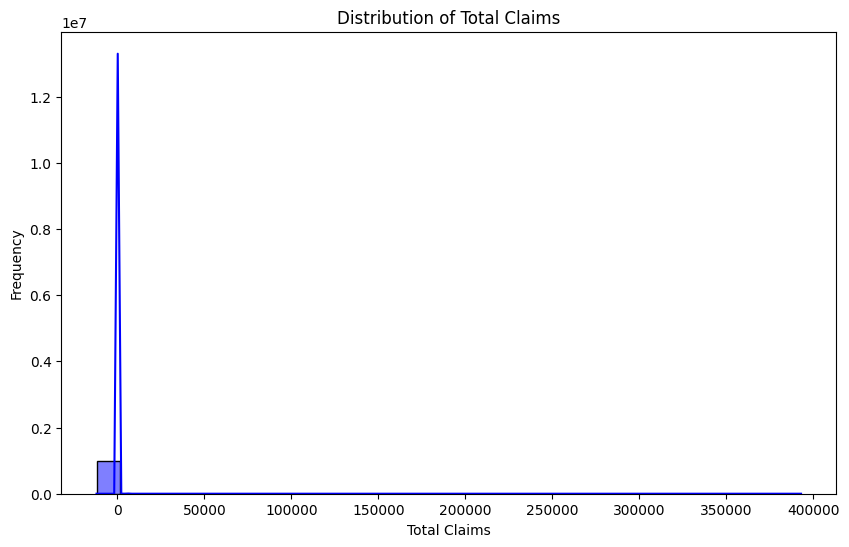

C:\Users\Daniel.Temesgen\AppData\Local\Temp\ipykernel_15292\51378834.py:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




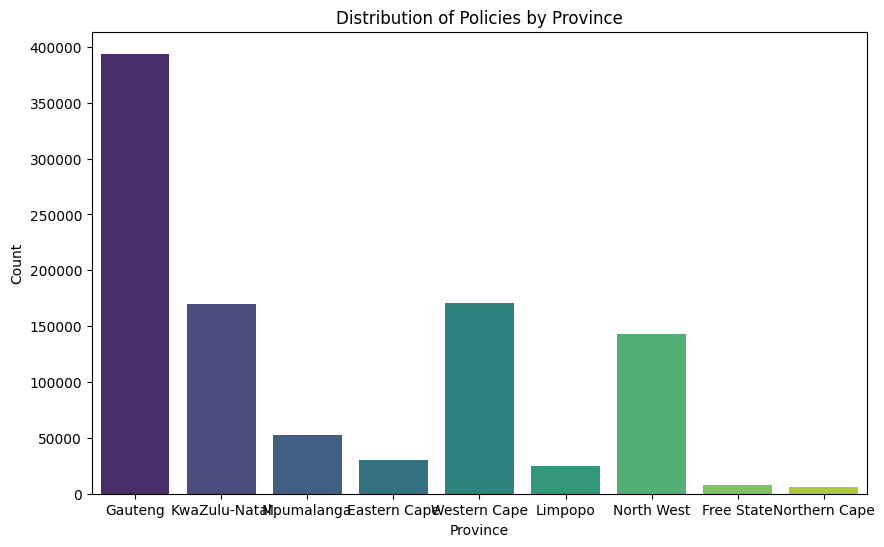

In [28]:
# Univariate Analysis
# Plot distributions for numerical (histograms) and categorical (bar charts) variables.

# Numerical: Histogram for TotalClaims
plt.figure(figsize=(10, 6))
sns.histplot(df['TotalClaims'], bins=30, kde=True, color='blue')
plt.title('Distribution of Total Claims')
plt.xlabel('Total Claims')
plt.ylabel('Frequency')
plt.show()

# Categorical: Bar chart for Province
plt.figure(figsize=(10, 6))
sns.countplot(x='Province', data=df, palette='viridis')
plt.title('Distribution of Policies by Province')
plt.xlabel('Province')
plt.ylabel('Count')
plt.show()

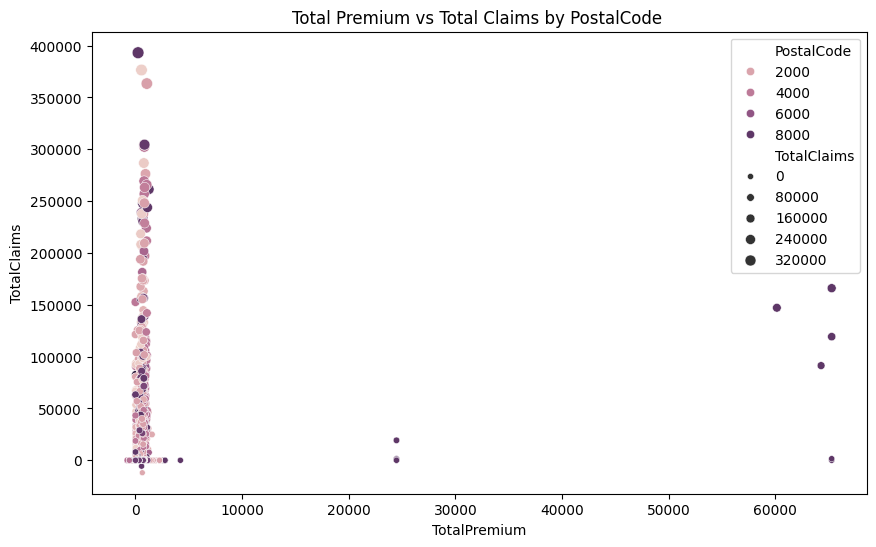

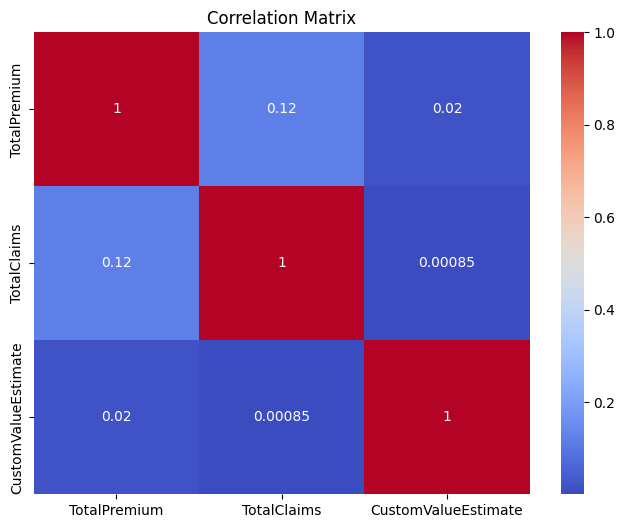

In [29]:
#Bivariate/Multivariate Analysis
# Scatter plot: TotalPremium vs TotalClaims by ZipCodeZip
plt.figure(figsize=(10, 6))
sns.scatterplot(x='TotalPremium', y='TotalClaims', hue='PostalCode', size='TotalClaims', data=df)
plt.title('Total Premium vs Total Claims by PostalCode ')
plt.show()

# Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df[['TotalPremium', 'TotalClaims', 'CustomValueEstimate']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

c:\Users\Daniel.Temesgen\Desktop\Insurance_Data\evenv\Lib\site-packages\numpy\_core\_methods.py:51: RuntimeWarning:

invalid value encountered in reduce




Overall Loss Ratio: nan

Loss Ratio by Province:
 Province
Eastern Cape          inf
Free State            inf
Gauteng               NaN
KwaZulu-Natal         inf
Limpopo               inf
Mpumalanga            NaN
North West            inf
Northern Cape    0.203831
Western Cape          inf
Name: LossRatio, dtype: float64

By VehicleType:
 VehicleType
Bus                       inf
Heavy Commercial          inf
Light Commercial     0.543917
Medium Commercial         inf
Passenger Vehicle         NaN
Name: LossRatio, dtype: float64

By Gender:
 Gender
Female           inf
Male             inf
Not specified    NaN
Name: LossRatio, dtype: float64


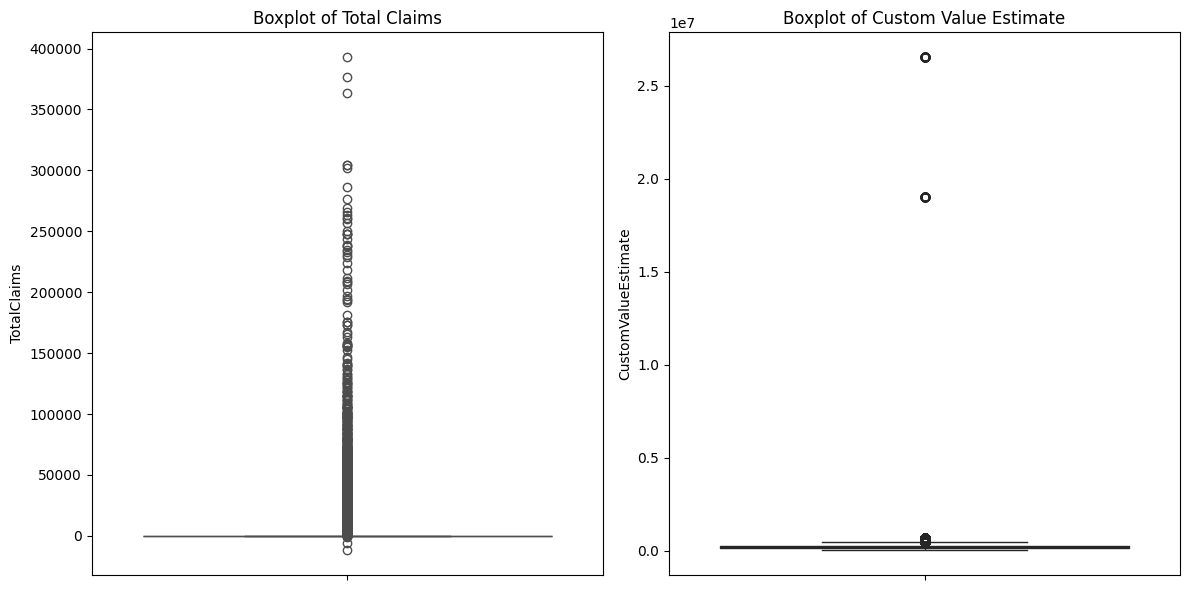

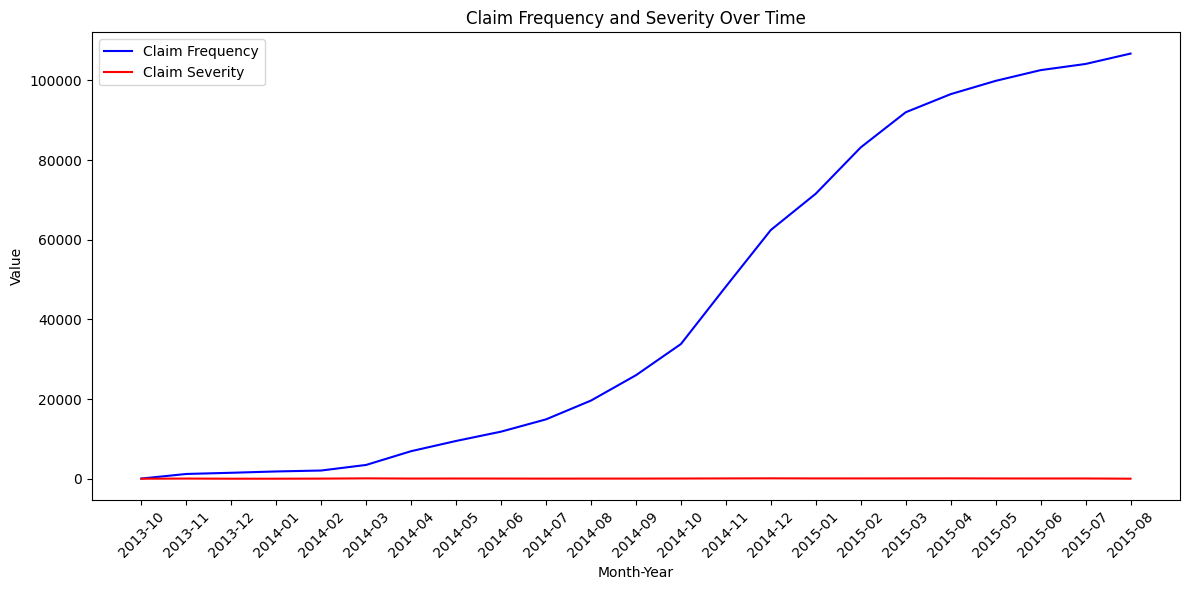


Claims by Vehicle Make:
 make
CITROEN                                  0.000000
CHERY                                    0.000000
FORD                                     0.000000
DAIHATSU                                 0.000000
GEELY                                    0.000000
HINO                                     0.000000
HUMMER                                   0.000000
HONDA                                    0.000000
JINBEI                                   0.000000
KIA                                      0.000000
LEXUS                                    0.000000
MAHINDRA                                 0.000000
PROTON                                   0.000000
RENAULT                                  0.000000
PEUGEOT                                  0.000000
OPEL                                     0.000000
TATA                                     0.000000
VOLVO                                    0.000000
SCANIA                                   0.000000
FOTON              

In [30]:
# Guiding Questions Answer the specific questions about loss ratio, distributions, trends, and vehicle makes.
# 1. Overall Loss Ratio and by Group
df['LossRatio'] = df['TotalClaims'] / df['TotalPremium']
print("\nOverall Loss Ratio:", df['LossRatio'].mean())

# By Province, VehicleType, Gender
print("\nLoss Ratio by Province:\n", df.groupby('Province')['LossRatio'].mean())
print("\nBy VehicleType:\n", df.groupby('VehicleType')['LossRatio'].mean())
print("\nBy Gender:\n", df.groupby('Gender')['LossRatio'].mean())


# 2. Outliers in TotalClaims and CustomValueEstimate
plt.figure(figsize=(12, 6))

# First subplot: Total Claims
plt.subplot(1, 2, 1)
sns.boxplot(y=df['TotalClaims'], color='blue')
plt.title('Boxplot of Total Claims')

# Second subplot: Custom Value Estimate
plt.subplot(1, 2, 2)
sns.boxplot(y=df['CustomValueEstimate'], color='green')
plt.title('Boxplot of Custom Value Estimate')

plt.tight_layout()
plt.show()

# 3. Temporal Trends (Claims over time)

df['MonthYear'] = df['TransactionMonth'].dt.to_period('M')
claims_by_month = df.groupby('MonthYear')['TotalClaims'].agg(['count', 'mean']).reset_index()
plt.figure(figsize=(12, 6))
plt.plot(claims_by_month['MonthYear'].astype(str), claims_by_month['count'], label='Claim Frequency', color='blue')
plt.plot(claims_by_month['MonthYear'].astype(str), claims_by_month['mean'], label='Claim Severity', color='red')
plt.title('Claim Frequency and Severity Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Value')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# 4. Vehicle Make by Claim Amount
print("\nClaims by Vehicle Make:\n", df.groupby('make')['TotalClaims'].mean().sort_values())

In [32]:
# Convert Period to datetime (start of the period)
claims_by_month['MonthYear'] = claims_by_month['MonthYear'].dt.to_timestamp()


In [33]:
#Plot insightful plots using plotly for interactivity

# 1. Interactive Scatter Plot
df['CustomValueEstimate'] = df['CustomValueEstimate'].fillna(0)  # or use mean, median, etc.
fig1 = px.scatter(df, x='TotalPremium', y='TotalClaims', color='VehicleType',
                  size='CustomValueEstimate', hover_data=['Province', 'make'],
                  title='Claims vs Premium by Vehicle Type')
fig1.show()

# 2. Interactive Bar Chart for Loss Ratio by Province
fig2 = px.bar(df.groupby('Province')['LossRatio'].mean().reset_index(), x='Province', y='LossRatio',
              color='Province', title='Average Loss Ratio by Province')
fig2.show()


# 3. Interactive Time Series
fig3 = px.line(claims_by_month, x='MonthYear', y=['count', 'mean'],
               title='Claim Frequency and Severity Over Time',
               labels={'value': 'Value', 'variable': 'Metric'})
fig3.show()
